# Quantum Fisher Information

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In this tutorial, we briefly introduce the concepts of the classical and quantum Fisher information, along with their applications in quantum machine learning, and show how to compute them with Paddle Quantum.

## Background

The quantum Fisher information (QFI) originates from the field of quantum sensing and have been versatile tools to study parameterized quantum systems [[1]](https://arxiv.org/abs/2103.15191), such as characterizing the overparameterization [[2]](https://arxiv.org/abs/2102.01659) and performing the quantum natural gradient descent [[3]](https://arxiv.org/abs/1909.02108). The QFI is a quantum analogue of the classical Fisher information (CFI). The CFI characterizes the sensibility of a parameterized **probability distribution** to parameter changes, while the QFI characterizes the sensibility of a parameterized **quantum state** to parameter changes.

In a traditional introduction, the CFI will appear as a quantity of parameter estimation in mathematical statistics, which might be complicated and confusing for the beginners. This tutorial will introduce the CFI from a geometric point of view, which is not only helpful for intuitive understanding, but also easier to see the relationship between the CFI and QFI.

### Classical Fisher information

Let's consider the classical Fisher information first. Suppose we now have a parameterized probability distribution $p(\boldsymbol{x};\boldsymbol{\theta})$. Here comes a question:

- How much does a small parameter change result in the probability distribution change ?

Since the question sounds like a perturbation problem, an intuition is to perform something like the Taylor expansion. But before expansion, we need to know which function to expand, i.e. we need to quantify the probability distribution change first. More formally, we need to define a distance measure between any two probability distributions, denoted by $d(p(\boldsymbol{x};\boldsymbol{\theta}),p(\boldsymbol{x};\boldsymbol{\theta}'))$, or $d(\boldsymbol{\theta},\boldsymbol{\theta}')$ for short.

Generally, a legal distance measure is supposed to be non-negative and equal to zero if and only if two points are identical, i.e.

$$
\begin{aligned}
&d(\boldsymbol{\theta},\boldsymbol{\theta}')\geq 0,\\
&d(\boldsymbol{\theta},\boldsymbol{\theta}')=0~\Leftrightarrow~\boldsymbol{\theta}=\boldsymbol{\theta}'.
\end{aligned}
\tag{1}
$$

Considering the expansion of a small distance $d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})$, the conditions above lead to

$$
\begin{aligned}
&d(\boldsymbol{\theta},\boldsymbol{\theta})=0~\Rightarrow~\text{the zero order}=0,\\
&d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\geq 0~\Rightarrow~\boldsymbol{\delta}=0~\text{takes minimum}
~\Rightarrow~\text{the first order}=0.
\end{aligned}
\tag{2}
$$

Thus, the second order is the lowest order that does not vanish in the expansion. So the expansion can be written as

$$
\begin{aligned}
d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})
=\frac{1}{2}\sum_{ij}\delta_iM_{ij}\delta_j+O(\|\boldsymbol{\delta}\|^3) 
=\frac{1}{2} \boldsymbol{\delta}^T M \boldsymbol{\delta} + O(\|\boldsymbol{\delta}\|^3),
\end{aligned}
\tag{3}
$$

where

$$
M_{ij}(\boldsymbol{\theta})=\left.\frac{\partial^2}{\partial\delta_i\partial\delta_j}d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\right|_{\boldsymbol{\delta}=0},
\tag{4}
$$

is exactly the Hessian matrix of the distance expansion, which is called [metric](http://en.wikipedia.org/wiki/Metric_tensor) of manifold in the context of differentiable geometry. The brief derivation above tells us that we can approximate a small distance as a quadratic form of the corresponding parameters, as shown in Fig.1, and the coefficient matrix  of the quadratic form is exactly the Hessian matrix from the distance expansion, up to a $1/2$ factor.

![feature map](./figures/FIM-fig-Sphere-metric.png "Figure 1. Approximate a small distance on the 2-sphere as a quadratic form")
<div style="text-align:center">Figure 1. Approximate a small distance on the 2-sphere as a quadratic form </div>

If the distance measure is specified to be the relative entropy / KL divergence, i.e.
$$
d_{\mathrm{KL}}(\boldsymbol{\theta}, \boldsymbol{\theta}^{\prime})=\sum_{\boldsymbol{x}} p(\boldsymbol{x};\boldsymbol{\theta}) \log \frac{p(\boldsymbol{x};\boldsymbol{\theta})}{p(\boldsymbol{x};\boldsymbol{\theta}^{\prime})}.
\tag{5}
$$

The corresponding Hessian matrix

$$
\begin{aligned}
\mathcal{I}_{ij}(\boldsymbol{\theta})&= \left.\frac{\partial^2}{\partial\delta_i\partial\delta_j}d_{\mathrm{KL}}(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\right|_{\boldsymbol{\delta}=0}\\
&=-\sum_{\boldsymbol{x}} p(\boldsymbol{x};\boldsymbol{\theta}) \partial_{i} \partial_{j} \log p(\boldsymbol{x};\boldsymbol{\theta})
=\mathbb{E}_{\boldsymbol{x}}[-\partial_{i} \partial_{j} \log p(\boldsymbol{x};\boldsymbol{\theta})] \\
&=\sum_{\boldsymbol{x}}  \frac{1}{p(\boldsymbol{x};\boldsymbol{\theta})} \partial_i p(\boldsymbol{x};\boldsymbol{\theta}) \cdot \partial_j p(\boldsymbol{x};\boldsymbol{\theta})
=\mathbb{E}_{\boldsymbol{x}}[\partial_i\log p(\boldsymbol{x};\boldsymbol{\theta})\cdot \partial_j \log p(\boldsymbol{x};\boldsymbol{\theta})].
\end{aligned}
\tag{6}
$$

is the so-called classical Fisher information matrix (CFIM), with large entries indicating large sensibility to the corresponding parameter changes. Here we use the notation $\partial_i=\partial/\partial \theta_i$.

Why is $\mathcal{I}(\boldsymbol{\theta})$ called "information"? Geometrically, the CFIM characterizes the sensitivity / sharpness of a probability distribution in the vicinity of $\boldsymbol{\theta}$. The more sensitive it is to a parameter change, the easier one can discriminate it from others, the fewer samples are needed to discriminate it, the more information per sample can give.

The measurement outcomes from a parameterized quantum circuit (PQC) form a parameterized probability distribution. So one can define a CFIM for each kind of measurement on a PQC. Currently, the main challenge of calculating CFIM on NISQ devices is that the number of possible measurement outputs increases exponentially with the number of qubits, which means that there may be many measurement outputs with low probabilities that never appear, leading to divergence in CFIM calculations. Possible solutions includes neglecting small probabilities (cause diverge) and Bayesian updating [[1]](https://arxiv.org/abs/2103.15191).

### Quantum Fisher information

The quantum Fisher information is a natural quantum analogue of the classical notion above, where the expanded distance is not defined between two probability distributions, but two quantum states. A common choice is the fidelity distance 

$$
d_f(\boldsymbol{\theta},\boldsymbol{\theta}')=2-2|\langle\psi(\boldsymbol{\theta})|\psi(\boldsymbol{\theta}')\rangle|^2.
\tag{7}
$$

where an additional factor $2$ here is manually multiplied to make the subsequent results resemble the CFIM. Hence formally, the quantum Fisher information matrix (QFIM) at a parameterized pure quantum state $|\psi(\boldsymbol{\theta})\rangle, \boldsymbol{\theta}\in\mathbb{R}^m$ is the Hessian matrix of the fidelity distance expansion, i.e.

$$
\begin{aligned}
\mathcal{F}_{ij}(\boldsymbol{\theta})
&= \left.\frac{\partial^2}{\partial\delta_i\partial\delta_j}d_{f}(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\right|_{\boldsymbol{\delta}=0} \\
&=4 \operatorname{Re}\left[\left\langle\partial_{i} \psi \mid \partial_{j} \psi\right\rangle - \left\langle\partial_{i} \psi \mid \psi\right\rangle\left\langle\psi \mid \partial_{j} \psi\right\rangle\right],
\end{aligned}
\tag{8}
$$

where we have omitted the argument $\boldsymbol{\theta}$ for simplicity. Similar to the CFIM, the QFIM characterizes the sensibility of a parameterized quantum state to a small change of parameters. In addition, it is worth mentioning that the QFIM can be seen as the real part of a complex matrix called the quantum geometric tensor, or say the Fubini-Study metric [[1]](https://arxiv.org/abs/2103.15191).

Currently, the community has developed some techniques to calculate the QFIM for pure states on NISQ devices, among which the two most straight methods are

- applying the second order parameter shift rule [[4]](https://arxiv.org/abs/2008.06517)
$$
\begin{aligned}
\mathcal{F}_{i j}=-\frac{1}{2} \Big(&|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}+(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}
-|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}+(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}\\
-&|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}-(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}
+|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}-(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}\Big),
\end{aligned}
\tag{9}
$$
where $\boldsymbol{e}_{i}$ denotes the unit vector corresponding to $\theta_i$. Note that the parameter shift rule can not be directly applied to the case where there are dependencies among parameters in single-qubit rotation gates, such as controlled rotation gates.

- applying the finite difference expression to calculate the projection along a certain direction [[1]](https://arxiv.org/abs/2103.15191)
$$
\boldsymbol{v}^{T} \mathcal{F} \boldsymbol{v} \approx \frac{4 d_{f}(\boldsymbol{\theta}, \boldsymbol{\theta}+\epsilon \boldsymbol{v})}{\epsilon^{2}}.
\tag{10}
$$
which can be regarded as the quantum analogue of the famed Fisher-Rao norm.

For mixed states, the QFIM can be defined by the expansion of the Bures fidelity distance

$$
d_B(\boldsymbol{\theta},\boldsymbol{\theta}')\equiv 
2-2\left[\text{Tr}\left([\sqrt{\rho(\boldsymbol{\theta})} \rho(\boldsymbol{\theta}')\sqrt{\rho(\boldsymbol{\theta})}]^{1/2}\right)\right]^2,
\tag{11}
$$

or equivalently ($\log x\sim x-1$), the $\alpha=1/2$ "sandwiched" Rényi relative entropy [[5]](https://arxiv.org/abs/1308.5961)

$$
\begin{aligned}
d_R(\boldsymbol{\theta},\boldsymbol{\theta}') &\equiv 2\widetilde{D}_{\alpha=1/2}(\rho(\boldsymbol{\theta'}) \| \rho(\boldsymbol{\theta})), \\
\widetilde{D}_{\alpha}(\rho \| \sigma) 
&\equiv 
\frac{1}{\alpha-1} \log \operatorname{Tr}\left[\left(\sigma^{\frac{1-\alpha}{2 \alpha}} \rho \sigma^{\frac{1-\alpha}{2 \alpha}}\right)^{\alpha}\right].\\
\end{aligned}
\tag{12}
$$

Please see the review [[1]](https://arxiv.org/abs/2103.15191) for more details.

### The relation between CFIM and QFIM

By definition, for a parameterized quantum circuit, the CFIM depends on the measurement bases while the QFIM does not. In fact, one can prove that the QFIM of a quantum state $\rho(\boldsymbol{\theta})$ is an upper bound of the CFIM obtained by arbitrary measurement from the same quantum state, i.e.

$$
\mathcal{I}[\mathcal{E}[\rho(\boldsymbol{\theta})]]\leq \mathcal{F}[\rho(\boldsymbol{\theta})],~\forall\mathcal{E},
\tag{13}
$$

where $\mathcal{E}$ denotes the quantum operation corresponding to the measurement, and the inequality between two positive matrices means that the large minus the small is still a positive matrix. This is a natural result since measurements can not extract more information than the quantum state itself, which mathematically stems from the monotonicity of the fidelity distance with respect to trace-preserving quantum operations [[1]](https://arxiv.org/abs/2103.15191).

### Application: effective dimension

The maximal rank of the CFIM / QFIM over the parameter space $\Theta$ is a quantity to characterize the **capacity** of a classical / quantum neural network, called effective classical / quantum dimension

$$
d_{\text{eff}}=\underset{\boldsymbol{\theta}\in\Theta} {\max}
\operatorname{rank}{\mathcal{F}}(\boldsymbol{\theta}).
\tag{14}
$$

The rank captures in how many directions parameter changes will result in the probability distribution / quantum state changes. A not-full rank means that some changes of parameters can not actually change the probability distribution / quantum state, or say there are redundant degrees of freedom of parameters that can be projected out and the model is therefore overparameterized. On the other hand, a larger effective dimension corresponds to more directions that can be extended, suggesting a more extensive space occupied by the model, i.e. a larger capacity.

In the context of machine learning, the so-called empirical CFIM [[6]](https://arxiv.org/abs/2011.00027) is more widely used, which is defined by a summation over samples instead of the expectation in the original definition

$$
\tilde{\mathcal{I}}_{ij}(\boldsymbol{\theta})
=\frac{1}{n}\sum_{k=1}^{n}
\partial_i\log p(x_k,y_k;\boldsymbol{\theta})
\partial_j\log p(x_k,y_k;\boldsymbol{\theta}),
\tag{15}
$$

where $(x_k,y_k)^{n}_{k=1}$ are identical independent distributed training data drawn from the distribution $p(x,y;\boldsymbol{\theta})=p(y|x;\boldsymbol{\theta})p(x)$. Clearly, the empirical CFIM can converge to the CFIM in the limit of infinite samples if (1) the model has been well-trained and (2) the model has enough capacity to cover the underlying data distribution. The advantage of the empirical CFIM is that it can be calculated directly using the training data at hand, instead of calculating the original integral by generating new samples. 

By use of the empirical CFIM, a variant of the effective dimension can be defined as

$$
d_{\text{eff}}(\gamma, n)=
2 \frac{\log \left(\frac{1}{V_{\Theta}} \int_{\Theta} \sqrt{\operatorname{det}\left( 1 + \frac{\gamma n}{2 \pi \log n} \hat{\mathcal{I}}( \boldsymbol{\theta})\right)} \mathrm{d}  \boldsymbol{\theta} \right)}
{\log \left(\frac{\gamma n}{2 \pi \log n}\right)},
\tag{16}
$$

where $V_{\Theta}:=\int_{\Theta} \mathrm{d} \boldsymbol{\theta} \in \mathbb{R}_{+}$ is the volume of the parameter space. $\gamma\in(0,1]$ is an artificial tunable parameter. $\hat{\mathcal{I}} (\boldsymbol{\theta}) \in \mathbb{R}^{d\times d}$ is the normalized empirical CFIM

$$
\hat{\mathcal{I}}_{i j}(\boldsymbol{\theta}):= \frac{V_{\Theta} d }{\int_{\Theta} \operatorname{Tr}(F( \boldsymbol{\theta} ) \mathrm{d} \theta} \tilde{\mathcal{I}}_{i j}(\boldsymbol{\theta}).
\tag{17}
$$

This definition might be strange and confusing at first glance, which is far more complicated than the maximal rank of the CFIM. However, it can converge to the maximal rank of the CFIM in the limit of infinite samples $n\rightarrow \infty$ [[6]](https://arxiv.org/abs/2011.00027). Regardless of the coefficients and the logarithm, the effective dimension here can be seen roughly as the geometric mean of the spectrum of the normalized CFIM plus an identity, then averaging over the parameter space. Associated with the inequality between the geometric mean and the arithmetic mean, we may expect that a more uniform empirical CFIM spectrum leads to a larger effective dimension, which is consistent with our natural impression. In this sense, it is a "soft" version of the effective dimension.

In addition, the Fisher information can not only provide an capacity measure, but also can serve as an indicator of trainability. If the entries of the Fisher information vanish exponentially with the system size averaging over the parameter space, i.e. the sensitivity becomes exponentially small, we can not distinguish them efficiently, which indicates the existence of barrens plateaus [[6]](https://arxiv.org/abs/2011.00027).

## Paddle Quantum Implementation

### Calculate the QFIM

With Paddle Quantum, one can obtain the QFIM conveniently by the following steps.

1. Define a quantum circuit using `Circuit`.
2. Define a `QuantumFisher` class as a calculator of the QFIM.
3. Use the method `get_qfisher_matrix()` to calculate the QFIM.

The calculator `QuantumFisher` will keep track of the change of the circuit `Circuit`.

Now let's code. Firstly, import packages.

In [1]:
import paddle
from paddle_quantum.ansatz import Circuit
import numpy as np
import matplotlib.pyplot as plt
from paddle_quantum.fisher import QuantumFisher, ClassicalFisher
import warnings
warnings.filterwarnings("ignore")

/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


Then, define a quantum circuit. As a simple example, we exploit a single qubit parameterized by two Bloch angles

$$
|\psi(\theta,\phi)\rangle=R_z(\phi)R_y(\theta)|0\rangle=e^{-i\phi/2}\cos\frac{\theta}{2}|0\rangle+e^{i\phi/2}\sin\frac{\theta}{2}|1\rangle.
\tag{18}
$$

The corresponding QFIM can be directly calculated using Eq.(8). The analytical result reads

$$
\mathcal{F}(\theta,\phi)=\left(\begin{matrix}
1&0\\
0&\sin^2\theta
\end{matrix}\right).
\tag{19}
$$

In [2]:
def circuit_bloch():
    cir = Circuit(1)
    cir.ry()
    cir.rz()
    return cir

In [3]:
cir = circuit_bloch()
print(cir)

--Ry(0.754)----Rz(6.117)--
                          


Define a QFIM calculator and calculate the QFIM element $\mathcal{F}_{\phi\phi}$ corresponding to different $\theta$.

In [4]:
qf = QuantumFisher(cir)
# Record the QFIM element F_{phi,phi}
list_qfisher_elements = []
num_thetas = 21
thetas = np.linspace(0, np.pi, num_thetas)
for theta in thetas:
    list_param = cir.param.tolist()
    list_param[0] = theta
    cir.update_param(list_param)
    # Calculate the QFIM
    qfim = qf.get_qfisher_matrix()
    print(f'The QFIM at {np.array(list_param)} is \n {qfim.round(14)}.')
    list_qfisher_elements.append(qfim[1][1])

The QFIM at [0.         6.11720181] is 
 [[1.00000024e+00 0.00000000e+00]
 [0.00000000e+00 2.38418590e-07]].
The QFIM at [0.15707963 6.11720181] is 
 [[1.00000024e+00 4.52859700e-08]
 [4.52859700e-08 2.44718779e-02]].
The QFIM at [0.31415927 6.11720181] is 
 [[1.00000024e+00 4.79417900e-08]
 [4.79417900e-08 9.54915827e-02]].
The QFIM at [0.4712389  6.11720181] is 
 [[1.00000000e+00 4.99490500e-08]
 [4.99490500e-08 2.06107258e-01]].
The QFIM at [0.62831853 6.11720181] is 
 [[1.00000024 0.        ]
 [0.         0.34549158]].
The QFIM at [0.78539816 6.11720181] is 
 [[ 1.00000024e+00 -6.65203000e-08]
 [-6.65203000e-08  5.00000213e-01]].
The QFIM at [0.9424778  6.11720181] is 
 [[1.00000024 0.        ]
 [0.         0.65450871]].
The QFIM at [1.09955743 6.11720181] is 
 [[1.00000000e+00 3.25239200e-08]
 [3.25239200e-08 7.93892663e-01]].
The QFIM at [1.25663706 6.11720181] is 
 [[1.         0.        ]
 [0.         0.90450854]].
The QFIM at [1.41371669 6.11720181] is 
 [[1.0000000e+00 4.5285

Plot the outputs of the QFIM element $\mathcal{F}_{\phi\phi}$ as function of $\theta$.

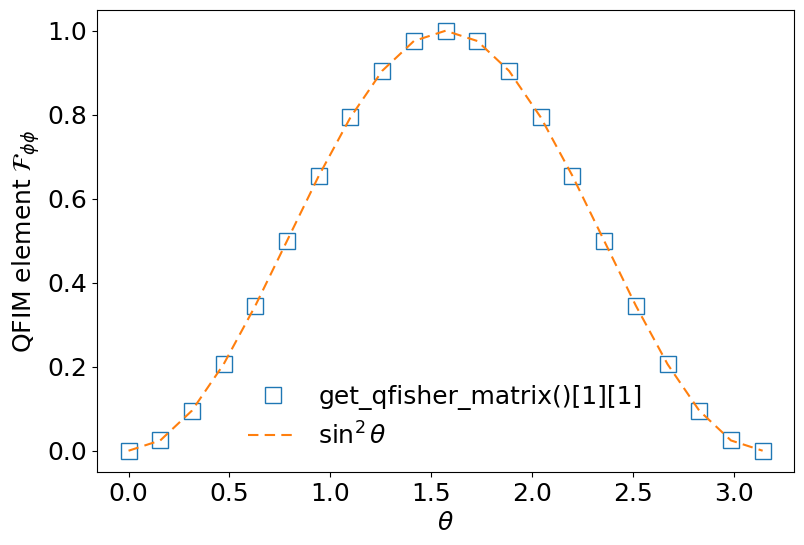

In [5]:
# Create a figure
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
# Plot the QFIM
ax.plot(thetas, list_qfisher_elements, 's', markersize=11, markerfacecolor='none')
# Plot sin^2 theta
ax.plot(thetas, np.sin(thetas) ** 2, linestyle=(0, (5, 3)))
# Set legends, labels, ticks
label_font_size = 18
ax.legend(['get_qfisher_matrix()[1][1]', '$\\sin^2\\theta$'], 
          prop= {'size': label_font_size}, frameon=False) 
ax.set_xlabel('$\\theta$', fontsize=label_font_size)
ax.set_ylabel('QFIM element $\\mathcal{F}_{\\phi\\phi}$', fontsize=label_font_size)
ax.tick_params(labelsize=label_font_size)

We can see that the outputs are consistent with the analytical results.

Moreover, one can use the method `get_qfisher_norm()` to calculate the quantum Fisher-Rao norm in Eq.(10), i.e. the QFIM projection along a certain direction.

As a different example, we exploit two qubits with a typical hardware-efficient ansatz

$$
|\psi(\boldsymbol{\theta})\rangle=\left[R_{y}\left( \theta_{3}\right) \otimes R_{y}\left( \theta_{4}\right)\right] \text{CNOT}_{0,1}\left[ R_{y}\left( \theta_{1}\right) \otimes R_{y}\left( \theta_{2}\right)\right]|00\rangle.
\tag{20}
$$

The corresponding QFIM reads

$$
\mathcal{F}(\theta_1,\theta_2,\theta_3,\theta_4)=\left(\begin{array}{cc|cc}
1 & 0 & \sin  \theta_{2} & 0 \\
0 & 1 & 0 & \cos  \theta_{1} \\
\hline 
\sin \theta_{2} & 0 & 1 & -\sin\theta_1\cos\theta_2 \\
0 & \cos \theta_{1} & -\sin\theta_1\cos\theta_2 & 1
\end{array}\right).
\tag{21}
$$

Define the corresponding quantum circuit.

In [6]:
def circuit_hardeff_2qubit():
    cir = Circuit(2)
    cir.ry()
    cir.cnot([0, 1])
    cir.ry()

    return cir

In [7]:
cir = circuit_hardeff_2qubit()
print(cir)

--Ry(5.330)----*----Ry(2.760)--
               |               
--Ry(4.243)----x----Ry(1.829)--
                               


Define a QFIM calculator and calculate the quantum Fisher-Rao norm $\boldsymbol{v}^T\mathcal{F}\boldsymbol{v}$ along the direction $\boldsymbol{v}=(1,1,1,1)$ corresponding to different $\theta$ (set $\theta_1=\theta_2=\theta$).

In [8]:
qf = QuantumFisher(cir)
v = [1, 1, 1, 1]
# Record the QFI norm
list_qfisher_norm = []
num_thetas = 41
thetas = np.linspace(0, np.pi * 4, num_thetas)
for theta in thetas:
    list_param = cir.param.tolist()
    list_param[0] = theta
    list_param[1] = theta
    cir.update_param(list_param)
    # 计算 QFIM 投影
    qfisher_norm = qf.get_qfisher_norm(v)
    print(
        f'The QFI norm along {v} at {np.array(list_param)} is {qfisher_norm:.8f}.'
    )
    list_qfisher_norm.append(qfisher_norm)

The QFI norm along [1, 1, 1, 1] at [0.         0.         2.75956345 1.82911766] is 5.99838655.
The QFI norm along [1, 1, 1, 1] at [0.31415927 0.31415927 2.75956345 1.82911766] is 5.91733027.
The QFI norm along [1, 1, 1, 1] at [0.62831853 0.62831853 2.75956345 1.82911766] is 5.83150589.
The QFI norm along [1, 1, 1, 1] at [0.9424778  0.9424778  2.75956345 1.82911766] is 5.83627391.
The QFI norm along [1, 1, 1, 1] at [1.25663706 1.25663706 2.75956345 1.82911766] is 5.93163433.
The QFI norm along [1, 1, 1, 1] at [1.57079633 1.57079633 2.75956345 1.82911766] is 6.00792258.
The QFI norm along [1, 1, 1, 1] at [1.88495559 1.88495559 2.75956345 1.82911766] is 5.85534601.
The QFI norm along [1, 1, 1, 1] at [2.19911486 2.19911486 2.75956345 1.82911766] is 5.38331038.
The QFI norm along [1, 1, 1, 1] at [2.51327412 2.51327412 2.75956345 1.82911766] is 4.49167993.
The QFI norm along [1, 1, 1, 1] at [2.82743339 2.82743339 2.75956345 1.82911766] is 3.28057238.
The QFI norm along [1, 1, 1, 1] at [3.14

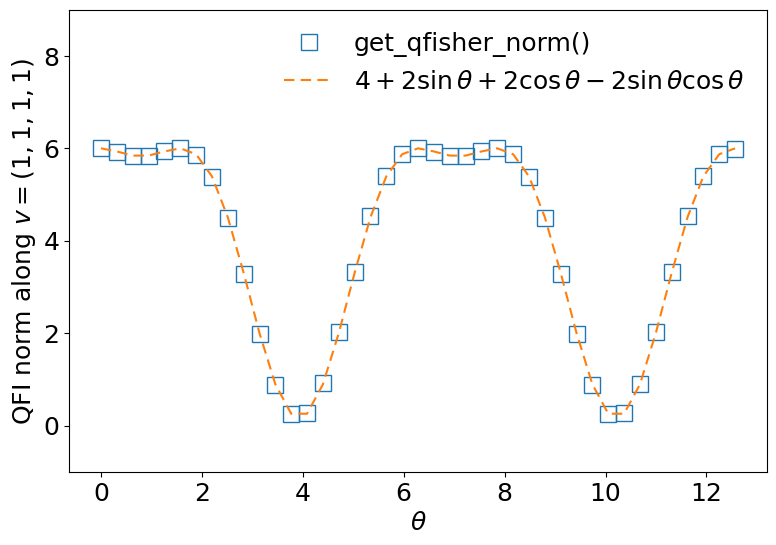

In [9]:
# Create a figure
fig= plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
# Plot the QFI norm
ax.plot(thetas, list_qfisher_norm, 's', markersize=11, markerfacecolor='none')
analytical_qfi_norm = 4 + 2 * np.sin(thetas) + 2 * np.cos(thetas) - 2 * np.cos(thetas) * np.sin(thetas)
ax.plot(thetas, analytical_qfi_norm, linestyle=(0, (5, 3)))
# Set legends, labels, ticks
ax.legend(
    ['get_qfisher_norm()', '$4+2\\sin\\theta+2\\cos\\theta-2\\sin\\theta\\cos\\theta$'], 
    loc='best', prop= {'size': label_font_size}, frameon=False,
)
ax.set_xlabel('$\\theta$', fontsize=label_font_size)
ax.set_ylabel('QFI norm along $v=(1,1,1,1)$', fontsize=label_font_size)
ax.set_ylim([-1, 9])
ax.tick_params(labelsize=label_font_size)

We can see that the outputs are consistent with the analytical results.

### Calculate the effective quantum dimension

With Paddle Quantum, one can obtain the effective quantum dimension (EQD) by simply using the method `get_eff_qdim()`. For example, the EQD of the hardware-efficient ansatz shown above can be calculated as follows.

In [10]:
cir = circuit_hardeff_2qubit()
qf = QuantumFisher(cir)
print(cir)
print(f'The number of parameters is {len(cir.param.tolist())}.')
print(f'The EQD is {qf.get_eff_qdim()}. \n')

--Ry(5.171)----*----Ry(3.574)--
               |               
--Ry(5.103)----x----Ry(1.247)--
                               
The number of parameters is 4.
The EQD is 3. 



In this example, the EQD is smaller than the number of parameters, which can be easily seen from the fact that the two $R_y$ gates on the control wire can be merged without changing anything. This inefficiency can be fixed by simply replacing one of the $R_y$ gates with a $R_x$ gate, and then the EQD will increase by one.

If we continue to add gates to the circuit, can we make the EQD grow indefinitely? The answer is clearly no. Provided $n$ qubits, an obvious upper bound can be given by the real number degrees of freedom in a general quantum state, which is equal to $2\cdot 2^n-2$. The minus two reflect the two constraints of normalization and global phase independence. This can be verified by the following example.

In [11]:
def circuit_hardeff_overparam():
    cir = Circuit(2)
    cir.ry()
    cir.rx()
    cir.cnot([0, 1])
    cir.ry()
    cir.rx()

    return cir


cir = circuit_hardeff_overparam()
qf = QuantumFisher(cir)
print(cir)
print(f'The number of parameters is {len(cir.param.tolist())}.')
print(f'The EQD is {qf.get_eff_qdim()}. \n')

--Ry(4.515)----Rx(5.898)----*----Ry(1.415)----Rx(2.717)--
                            |                            
--Ry(1.522)----Rx(2.778)----x----Ry(3.684)----Rx(0.956)--
                                                         
The number of parameters is 8.
The EQD is 6. 



### Calculate the CFIM and effective dimension

Here we exploit a brief example to show how to calculate the effective dimension defined in Eq.(16) with respect to a quantum neural network with Paddle Quantum.

Define our quantum neural network along with the loss function using PaddlePaddle.

In [12]:
import paddle.nn as nn
from paddle_quantum.ansatz.layer import ComplexEntangledLayer
from paddle_quantum.gate import IQPEncoding, RX
from paddle_quantum.loss import ExpecVal
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.state import zero_state

class QuantumNeuralNetwork(nn.Layer):
    def __init__(self, num_qubits, depth, encoding):
        super().__init__()
        self.num_qubits, self.encoding = num_qubits, encoding
        self.S = [[i, i + 1] for i in range(num_qubits - 1)]
        self.init_state = zero_state(num_qubits)
        self.loss_func = ExpecVal(Hamiltonian([[1.0, 'z0']]))
        
        if encoding == 'IQP':
            self.complex_layer = nn.LayerList([ComplexEntangledLayer(num_qubits=num_qubits, depth=depth)])
        elif encoding == 're-uploading':
            self.complex_layers = nn.LayerList([ComplexEntangledLayer(num_qubits=num_qubits) for _ in range(depth + 1)])
        else:
            raise RuntimeError('Non-existent encoding method')

    def forward(self, x):
        if not paddle.is_tensor(x):
            x = paddle.to_tensor(x, dtype='float32')

        state = self.init_state
        if self.encoding == 'IQP':
            state = IQPEncoding(x, qubits_idx=self.S)(state)
            state = self.complex_layer[0](state)
        else:
            for i in range(depth):
                state = self.complex_layers[i](state)
                for j in range(num_qubits):
                    state = RX(j, param=x[j].item())(state)
            state = self.complex_layers[depth](state)

        return self.loss_func(state) * 0.5 + 0.5

Finally, define a CFIM calculator and calculate the effective dimension corresponding to different size of training samples.

In [13]:
from paddle_quantum import set_backend

# Configure model parameters
num_qubits = 4
depth = 2
num_inputs = 100
num_thetas = 10
set_backend('state_vector')
# Define the CFIM calculator
cfim = ClassicalFisher(model=QuantumNeuralNetwork,
                       num_thetas=num_thetas,
                       num_inputs=num_inputs,
                       num_qubits=num_qubits,
                       depth=depth,
                       encoding='IQP')
# Compute the normalized classical Fisher information
fim, _ = cfim.get_normalized_cfisher()
# Compute the effective dimension for different size of samples
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
effdim = cfim.get_eff_dim(fim, n)

running in get_gradient: 100%|##################################| 1000/1000 [00:26<00:00, 37.54it/s]


Plot the ratio of the effective dimension over number of parameters vs. sample size.

the number of parameters: 24


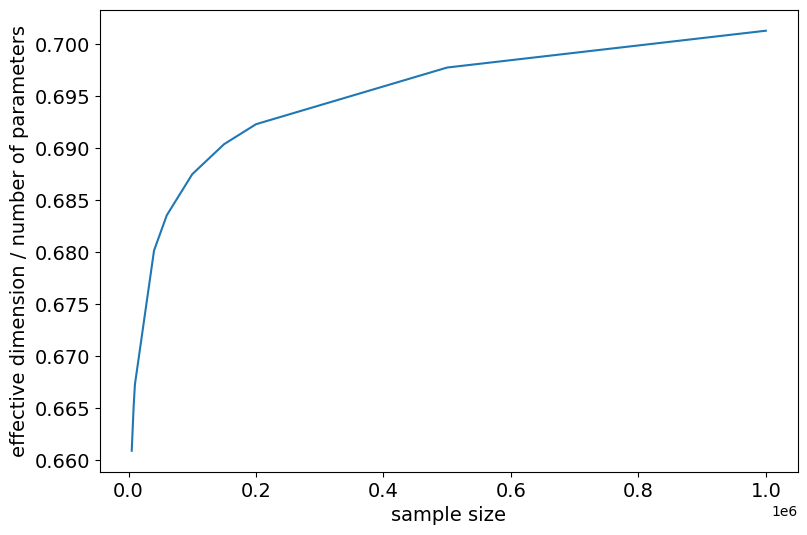

In [14]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
print('the number of parameters: %s' % cfim.num_params)
ax.plot(n, np.array(effdim) / cfim.num_params)
label_font_size = 14
ax.set_xlabel('sample size', fontsize=label_font_size)
ax.set_ylabel('effective dimension / number of parameters', fontsize=label_font_size)
ax.tick_params(labelsize=label_font_size)

## Conclusion

This tutorial briefly introduces the concept of classical and quantum Fisher information and their relationship from a geometric point of view. Then, we illustrates their applications in quantum machine learning by taking effective dimension as an example. Finally, we show how to actually perform calculations of these quantities with Paddle Quantum.

_______

## References

[1] Meyer, Johannes Jakob. "Fisher information in noisy intermediate-scale quantum applications." [arXiv preprint arXiv:2103.15191 (2021).](https://arxiv.org/abs/2103.15191)

[2] Haug, Tobias, Kishor Bharti, and M. S. Kim. "Capacity and quantum geometry of parametrized quantum circuits." [arXiv preprint arXiv:2102.01659 (2021).](https://arxiv.org/abs/2102.01659)

[3] Stokes, James, et al. "Quantum natural gradient." [Quantum 4 (2020): 269.](https://quantum-journal.org/papers/q-2020-05-25-269/)

[4] Mari, Andrea, Thomas R. Bromley, and Nathan Killoran. "Estimating the gradient and higher-order derivatives on quantum hardware." [Physical Review A 103.1 (2021): 012405.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.012405)

[5] Datta, Nilanjana, and Felix Leditzky. "A limit of the quantum Rényi divergence." [Journal of Physics A: Mathematical and Theoretical 47.4 (2014): 045304.](https://iopscience.iop.org/article/10.1088/1751-8113/47/4/045304)

[6] Abbas, Amira, et al. "The power of quantum neural networks." [Nature Computational Science 1.6 (2021): 403-409.](https://www.nature.com/articles/s43588-021-00084-1)